# The Preface

In [1]:
import warnings
import requests

import data_loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO

import seaborn as sns
sns.set()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.neighbors import kneighbors_graph

import networkx as nx
import pickle

from scipy.sparse.linalg import eigs

# Data Cleaning
We implemented data cleaning in the file `src/data_cleaning.py`. The encountered issues are explained in `src/data_cleaning.ipynb`.

# Datasets

### Votes

In [2]:
votes = data_loading.votes()
votes.head()

,15,21,26,28,34,61,70,74,76,91,...,4224,4225,4226,4227,4228,4229,4230,4232,4234,4236
Id,,,,,,,,,,,,,,,,,,,,,
1-10695,0,-1,3,3,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1-11842,1,-1,1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1-11843,1,-1,1,2,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1-14447,-1,-1,-1,-1,-1,-1,-1,1,-1,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1-15286,-1,-1,-1,-1,-1,-1,-1,0,-1,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


The `votes` dataframe has as index a unique vote-id, as columns a unique councillor-id and as values the response of the councillor for the given vote. The encoding of the values is as follows:
- 0: No
- 1: Yes
- 2: Abstained
- 3: Did Not Participate
- 4: Excused
- 5: President

Values 2 to 5 mean that councillor did not participate in the vote.

### Members

In [3]:
members = data_loading.members()
members.head(3)

,Active,FirstName,LastName,GenderAsString,CantonName,CantonAbbreviation,CouncilName,ParlGroupName,ParlGroupAbbreviation,PartyName,PartyAbbreviation,MaritalStatusText,BirthPlace_City,BirthPlace_Canton,Mandates,DateJoining,DateLeaving,Citizenship,DateOfBirth,DateOfDeath
0,False,Fabio,Abate,m,Tessin,TI,Conseil national,Groupe radical-libéral,RL,Parti radical-démocratique suisse,PRD,NaN,Locarno,Tessin,Incarichi esecutivi presso il comune di Locarn...,2007-12-03,2011-12-04,Cabbio (TI),1966-01-04,NaT
1,False,Fabio,Abate,m,Tessin,TI,Conseil des Etats,Groupe libéral-radical,RL,PLR.Les Libéraux-Radicaux,PLR,NaN,Locarno,Tessin,Incarichi esecutivi presso il comune di Locarn...,2011-12-05,2015-11-29,Cabbio (TI),1966-01-04,NaT
2,True,Fabio,Abate,m,Tessin,TI,Conseil des Etats,Groupe libéral-radical,RL,PLR.Les Libéraux-Radicaux,PLR,NaN,Locarno,Tessin,Incarichi esecutivi presso il comune di Locarn...,2015-11-30,2019-12-01,Cabbio (TI),1966-01-04,NaT


The `members` dataframe contains background information of all members of the three swiss councils in the period from 2007 to 2019.

### Full Votes

In [4]:
full_votes = data_loading.full_votes()
with pd.option_context("display.max_columns", None):
    display(full_votes.head(3))

,Active,AffairShortId,AffairTitle,BirthPlace_Canton,BirthPlace_City,CantonAbbreviation,CantonName,Citizenship,CouncilName,CouncillorAbstain,CouncillorExcused,CouncillorId,CouncillorName,CouncillorNo,CouncillorNotParticipated,CouncillorPresident,CouncillorYes,DateJoining,DateLeaving,DateOfBirth,DateOfDeath,DivisionText,FirstName,GenderAsString,LastName,Mandates,MaritalStatusText,ParlGroupAbbreviation,ParlGroupName,PartyAbbreviation,PartyName,VoteDate,VoteFilteredAbstain,VoteFilteredExcused,VoteFilteredNo,VoteFilteredNotParticipated,VoteFilteredPresident,VoteFilteredYes,VoteMeaningNo,VoteMeaningYes,VoteRegistrationNumber,VoteSubmissionText
0,False,20070464,Prorogation de la loi fédérale sur l'adaptatio...,Vaud,Lausanne,VD,Vaud,Paudex (VD),Conseil national,0,0,3923,Marra Ada,0,0,0,1,2007-12-03,2011-12-04,1973-03-10,NaT,Ja,Ada,f,Marra,Législatif cantonal: depuis décembre 2004 jusq...,NaN,S,Groupe socialiste,PSS,Parti socialiste suisse,2007-12-21 09:50:38,1,0,1,1,1,196,NaN,NaN,248,Vote final
1,False,20070464,Prorogation de la loi fédérale sur l'adaptatio...,Valais,Sierre,VD,Vaud,Champvent (VD),Conseil national,0,0,3883,Glauser-Zufferey Alice,0,0,0,1,2007-12-03,2011-12-04,1954-10-18,NaT,Ja,Alice,f,Glauser-Zufferey,Constituante vaudoise: de 2000 à 2002; Municip...,NaN,V,Groupe de l'Union démocratique du Centre,UDC,Union Démocratique du Centre,2007-12-21 09:50:38,1,0,1,1,1,196,NaN,NaN,248,Vote final
2,False,20070464,Prorogation de la loi fédérale sur l'adaptatio...,Soleure,Soleure,VD,Vaud,"Ste-Croix (VD),Villarzel (VD)",Conseil national,0,0,3907,Thorens Goumaz Adèle,0,0,0,1,2007-12-03,2011-12-04,1971-12-15,NaT,Ja,Adèle,f,Thorens Goumaz,Conseillère communale à Lausanne: depuis 2002 ...,NaN,G,Groupe des Verts,PES,Parti écologiste suisse,2007-12-21 09:50:38,1,0,1,1,1,196,NaN,NaN,248,Vote final


The `full_votes` dataframe contains all votes in the national council between 2007 and 2019. It was joined with the members dataframe and contains also all background information for the respective councillors at that time. Note that the background information on a councillor changes over time as they might, for example, change party. The dataframe contains information for about 13500 votes (13500 * 200 rows in total as the national council has 200 members).

# 1. Politician Representations
In the following section, we create different representations for the politicians. In particular, we reduce their voting behavior down to its principal components, explore the manifold of politicians using TSNE and create a nearest-neighbor graph of politicians. We will then reuse the different representations of politicians in order to validate the results of our analysis.

### Missing Values
Impute missing values with the mean along the rows. Reasoning: If a parlamentarian didn't participate in the vote, we want him to be as neutral as possible, such that he isn't defined by votes he didn't participate in.

In [5]:
yesno = votes.copy()
yesno[yesno>1] = np.NaN
yesno[yesno<0] = np.NaN

In [6]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
yesno_imp = imp.fit_transform(yesno.T).T

## 1.1 Global PCA
We start off by reducing the politician votes to its principal components using principal component analysis (PCA) of the entire dataset. 

In [7]:
def do_pca(data, explained_var=.75, return_fits=True):
    """
    Rescales variables to have mean zero, then performs PCA.
    
    Parameters
    ----------
    data:
        Data to transform. Rows are observations, columns are features
    explained_var:
        Retains enough principal components to explain "explained_var" percent
        of the total variance
    return_fits:
        If true, returns the rescale fit and the pca fit together with the principal components.
        Otherwise returns only principal components.
    """
    
    # Fit scaler and PCA
    scalefit = StandardScaler(with_std=False).fit(data)
    scaled = scalefit.transform(data)
    pcafit = PCA().fit(scaled)
    
    # Get nb pcs to retain
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    nb_retain = np.where(expl_var>.75)[0][0]
    
    # Project onto PCs
    pc = pcafit.transform(scaled)[:,:nb_retain]
    
    if return_fits:
        return pc, scalefit, pcafit
    else:
        return pc

pc, scalefit, pcafit = do_pca(yesno_imp.T)

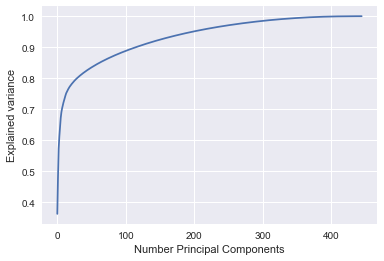

In [8]:
def explained_variance_plot(pcafit):
    expl_var = np.cumsum(pcafit.explained_variance_ratio_)
    plt.plot(expl_var)
    plt.ylabel("Explained variance")
    plt.xlabel("Number Principal Components")

explained_variance_plot(pcafit)
plt.show()

Very few principal components seem to explain 75% of the data variance already. We thus retain only those principal components for the future analysis.

#### Validation of PCA

*Vote Importance Score*<br>
From the PCA, we can construct an importance score for every individual vote: We do so by determining how much each vote contributes to the most important principal components. A high score means that a vote is very important for determining the politician's general location in the reduced space. We can thus validate the quality of our PCA by looking at the most- and least important votes and determine whether they make sense from a politological point of view.

In [9]:
def vote_importance_score(pc, pcafit):
    """
    Determines vote importance as the summed contribution of the vote to the retained 
    principal components.
    """
    nb_retain = pc.shape[1]
    return np.abs(pcafit.components_[:nb_retain,:]).sum(axis=0)

vote_importance = vote_importance_score(pc, pcafit)

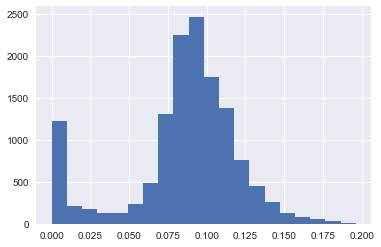

In [10]:
plt.hist(vote_importance, bins=20)
plt.show()

> TODO: Look at the outliers in both directions, see whether they make sense. If yes: Good pca, if not: Bad PCA

*Interpretation of the principal direction*<br>
Another way to validate the PCA is to see whether we can find an interpretation of the principal directions. To this effect, we correlate the principal component scores of the politicians with other attributes known about them, such as their age, gender, number of votes they participated in, etc.

> Moreover it would be interesting to correlate the principal components with other interesting variables about the politicians, such as gender, age, legislature or language, to see whether our principal components have a real-life interpretation.

## 1.2 Non-linear Embedding in 2D with t-SNE

Using the principal component analysis, we embedded the data into a lower-dimensional space using a linear transformation. In order to visualize the data, we need to further reduce it to two dimensions. For this we rely on the non-linear two-dimensional embedding obtained with the t-distributed stochastic neighborhood embedding (t-SNE) algorithm. This algorithm reduces similar politicians to nearby points, whereas dissimilar politicians are far from each other. By doing so it can reveal clusters when they are present in the data. 

In [11]:
def do_tsne(pc):
    return TSNE(random_state=42).fit_transform(pc)

tsne = do_tsne(pc)

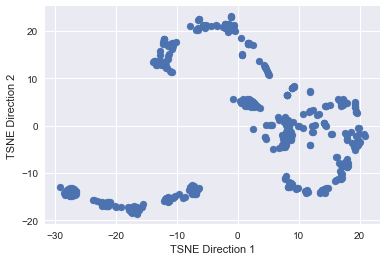

In [12]:
def plot_tsne(tsne):
    plt.scatter(tsne[:,0], tsne[:,1])
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")

plot_tsne(tsne)
plt.show()

The TSNE plot indicates that certain politicians group together, which manifests in several clusters forming. However, note that the results of the TSNE should be taken with a grain of salt, since its complexity sometimes leads to unexpected results.

## 1.3 Graph Representation
A third way to represent the politicians will be in the form of an undirected graph. The graph is imputed such that every politician is connected to his k nearest neighbors in space. For technical reasons, we want the resulting graph to be connected. Moreover, we will assign as the weight between the two politicians $p_1$ and $p_2$ to be:
$\quad w_{ij} = \exp \{ \frac{1}{2\sigma^2} \|p_1 - p_2\|_2^2 \}$

In [13]:
def get_knn_graph(pc, k=10):
    """
    Obtains knn_graph, returns networkX weighted graph object.
    
    Parameters
    ----------
    pc:
        Principal components for graph imputation
    k:
        Number of nearest neighbors to consider
    """
    knn_graph = kneighbors_graph(pc, k, mode="connectivity")

    # Create networkx object
    nx_graph = nx.from_scipy_sparse_matrix(knn_graph)
    if not nx.is_connected(nx_graph):
        warnings.warn("Resulting graph is not connected, spectral embedding may give unexpected results")
    return nx_graph

knn_graph = get_knn_graph(pc, k=10)
knn_graph_plot_pos = nx.spring_layout(knn_graph)

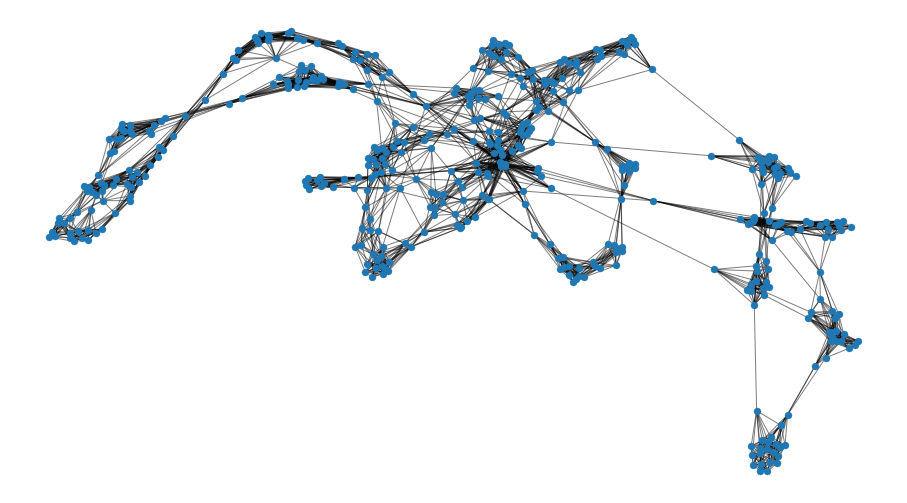

In [14]:
def draw_graph(G, pos=None):
    if pos is None:
        pos=nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, alpha=.5)
    plt.axis('off')
    
plt.figure(figsize=(16,9))
draw_graph(knn_graph, knn_graph_plot_pos)

**Spectral Embedding**<br>
The spectral embedding embeds the graph into a n-dimensional space. This can be used for visualizing the graph itself or for spectral clustering, as used below. 
<br><br>
Reference:
*U. Von Luxburg*, “A tutorial on spectral clustering,” *Stat. Comput., vol. 17, no. 4, pp. 395–416, 2007.*

In [15]:
def spectral_embedding(nx_graph, n=15):
    """
    Calculates spectral embedding based on normalized Laplacian matrix.
    
    Parameters
    ----------
    nx_graph:
        NetworkX graph to analyze
    n_evals:
        Number of smallest eigenvalues and corresponding eigenvectors to be computed
        
    Returns
    -------
    evals:
        Eigenvalues of spectral embedding
    evecs:
        Eigenvectors of spectral embedding
    """
    norm_L = nx.normalized_laplacian_matrix(nx_graph)
    evals, evecs = eigs(norm_L, k=n, which="SM")
    evals = np.real(evals)
    evecs = np.real(evecs)
    return evals, evecs

sp_evals, sp_evecs = spectral_embedding(knn_graph)

#### Validation
We validate the graph by looking at its properties.


*Node degree distribution*

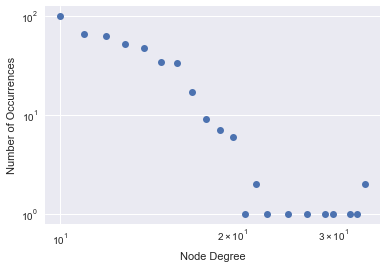

In [16]:
def plot_degree_distribution(graph):
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")
plot_degree_distribution(knn_graph)

Here, we plot the node degree distribution. We see that it is heavy-tailed, roughly follows a power law. This behavior is typical for social networks, which suggests that our graph is an adequate representation for the political landscape.

## 1.4 Saving Intermediary Results

In [17]:
np.save("../generated/politician_pc", pc)
np.save("../generated/politician_tsne", tsne)
with open('../generated/politician_graph.pickle', 'wb') as file:
    pickle.dump(knn_graph, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('../generated/politician_graph_plot_pos.pickle', 'wb') as file:
    pickle.dump(knn_graph_plot_pos, file, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Recovering Clusters

## 2.1 K-Means Clustering

We perform k-means clustering in order to cluster our politicians based on their voting behavior. We do this on the principal components calculated above, in order to avoid the curse of dimensionality.

We run k-means clustering with a range of possible number of clusters. Then, we determine the optimal number of clusters using a so-called knee-plot, which plots the within-cluster variance against the number of clusters. 

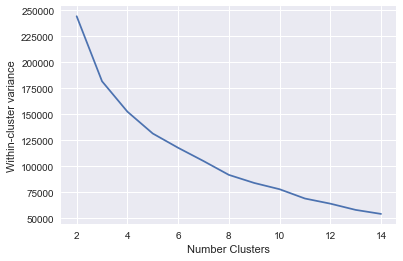

In [18]:
cluster_range = np.arange(2, 15)
kmeans_fit = []
inertia = []
for nc in cluster_range:
    cl = KMeans(n_clusters=nc).fit(pc)
    kmeans_fit.append(cl)
    inertia.append(cl.inertia_)
    
plt.plot(cluster_range, inertia)
plt.ylabel("Within-cluster variance")
plt.xlabel("Number Clusters")
plt.show()

In the knee-plot, the optimal number of clusters can be determined as the "knee" of the graph. In our case, this is somewhat hard to determine, but 6 clusters seem plausible.

In [19]:
ix = np.where(cluster_range==6)[0][0]
kmeans_cl = kmeans_fit[ix].labels_

## 2.2 Graph Based Clustering
In order to validate the clustering, we compare the results with graph-based clustering. For this we impute a graph of politicians as a k-nearest-neighbor graph, where we connect every politician to their k nearest neighbors in the space of the most important principal components. This allows us to perform spectral clustering on the resulting graph.

#### Spectral Clustering
From the spectral decomposition, we can obtain the number of clusters in the graph with the so-called eigengap heuristic: According to it, the number of clusters is given by the value $k$ that maximizes the difference of consecutive eigenvalues.

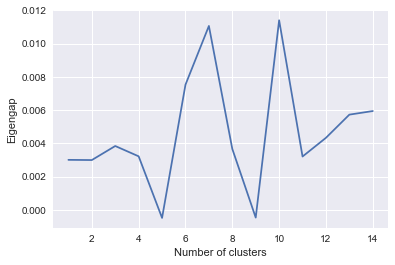

In [20]:
def plot_eigengap(evals):
    n_evals = len(evals)
    
    plt.plot(np.arange(1, n_evals), sp_evals[1:] - sp_evals[:-1])
    plt.xlabel("Number of clusters")
    plt.ylabel("Eigengap")
    plt.show()
    
plot_eigengap(sp_evals)

The plot suggests that $k=7$ or $k=10$ clusters seem to be present within the graph. We determine the cluster assingment as follows: We take the $k$ first dimensions of the spectral embedding and perform k-means clustering in that space.

In [21]:
def spectral_clustering(evecs, k):
    red = evecs[:,:k]
    clusters = KMeans(n_clusters=k).fit_predict(red)
    return clusters

spec_cl_10 = spectral_clustering(sp_evecs, 10)
spec_cl_7 = spectral_clustering(sp_evecs, 7)

## 2.3 Clustering Result Comparison
We now go back to our TSNE plot to visualize the different clusterings we obtained so far.

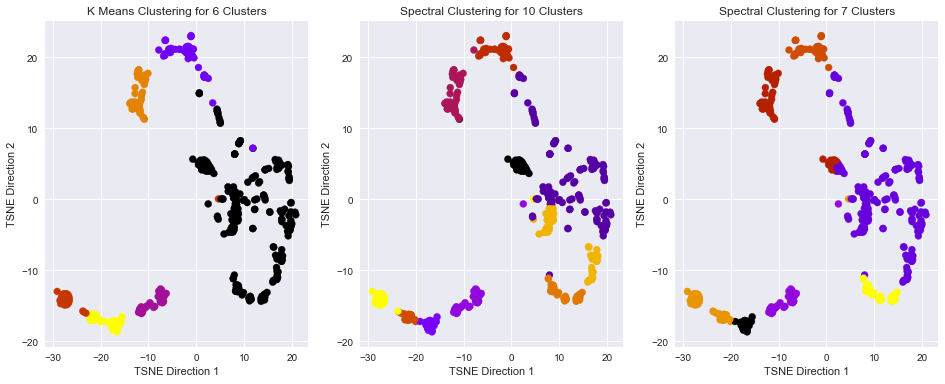

In [42]:
def visualize_clusterings(coordinates, clusters):
    plt.scatter(coordinates[:,0], coordinates[:,1], c=clusters, cmap="gnuplot")
    plt.xlabel("TSNE Direction 1")
    plt.ylabel("TSNE Direction 2")
    
plt.figure(figsize=(16,6))

plt.subplot(131)
plt.title("K Means Clustering for 6 Clusters")
visualize_clusterings(tsne, kmeans_cl)

plt.subplot(132)
plt.title("Spectral Clustering for 10 Clusters")
visualize_clusterings(tsne, spec_cl_10)

plt.subplot(133)
plt.title("Spectral Clustering for 7 Clusters")
visualize_clusterings(tsne, spec_cl_7)


We observe that the three clustering procedures seem to cluster similarly. Moreover, the clusters seem to be in accordance to what can visually be identified as clusters on the TSNE plots. This suggests that the clustering is pretty robust, which in turn indicates that politicians seem to form clusters.

# 3. The Swiss Executive Power 
In Switzerland the executive branch of government consists of a council of 7 people which are chosen to roughly represent the political landscape of Switzerland. In this part we ask whether political parties are necessary to form this executive council or whether other ways could be found to choose suitable people.

## 3.1 Finding the Federal counselors
The first step is to find the politician that went on to become federal counselors and whose voting behavior is in our database.

First let's create a DataFrame with all federal counselor and their CouncillorId

In [23]:
federal_counselor = members.loc[members["CouncilName"] == "Conseil fédéral"][['FirstName','LastName']].drop_duplicates()
federal_counselor = federal_counselor.set_index(['FirstName','LastName'])
federal_counselor_votes = full_votes.join(federal_counselor,on=['FirstName','LastName'],how="right")
federal_counselor_votes = federal_counselor_votes[["FirstName","LastName","PartyAbbreviation","CouncillorId"]].groupby("CouncillorId").last()
federal_counselor_votes.index = federal_counselor_votes.index.map(int)
federal_counselor_votes

,FirstName,LastName,PartyAbbreviation
CouncillorId,,,
21,Christoph,Blocher,UDC
146,Ueli,Maurer,UDC
508,Johann N.,Schneider-Ammann,PRD
1108,Guy,Parmelin,UDC
1116,Didier,Burkhalter,PRD
1288,Viola,Amherd,PDC
3828,Ignazio,Cassis,PLR


We see that our analysis will be limited by the fact that only seven federal conselor's voting record are in the database. This is too few datapoint to derive some meaningful conclusion but it is still interesting to analyse those points.

In [24]:
CouncillorId_to_idx = dict(zip(votes.T.index.map(int),range(len(votes.T))))
ids_to_CouncillorId = dict(zip(range(len(votes.T)),votes.T.index.map(int)))

In [25]:
federal_counselor_votes["idx"]= list(map(lambda x :CouncillorId_to_idx[int(x)],federal_counselor_votes.index))

## 3.2 Visualizing the Executive Power 

Now let's see where those politicians are in the representation of our data we made above.

In [26]:
def write_names(first,last,party):
        return first + " " +last + " (" + party + ")"
# Defining a unified color code for the federal counselors
colors = ['xkcd:red','xkcd:highlighter green','xkcd:hot pink','xkcd:orange yellow','xkcd:lilac','xkcd:coffee','xkcd:bright turquoise']

### 2.2.1 TSNE Representation

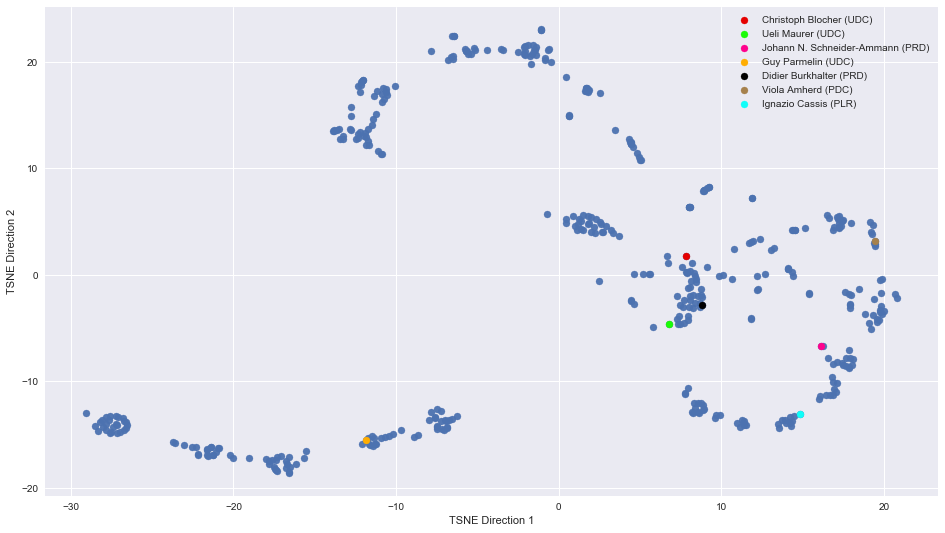

In [30]:
def highlight_nodes_tsne(councelor_df,tsne):
    plt.figure(figsize=(16,9))
    def plot_tsne(tsne):
        plt.scatter(tsne[:,0], tsne[:,1],alpha=0.95)
        plt.xlabel("TSNE Direction 1")
        plt.ylabel("TSNE Direction 2")

    plot_tsne(tsne)
    labels = [write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()]
    idx = councelor_df["idx"].values
    colors = ['xkcd:red','xkcd:highlighter green','xkcd:hot pink','xkcd:orange yellow','xkcd:black','xkcd:coffee','xkcd:bright turquoise']
    for c,(id_,l) in zip(colors,zip(idx,labels)):
        plt.scatter(tsne[id_,0], tsne[id_,1],label=l,c=c)
    plt.legend()
    plt.show()
    
highlight_nodes_tsne(federal_counselor_votes,tsne)

Here we see that the counselors seem to be concentrated near the middle, none of them too isolated. It is noteworthy that member of same party such as Chrisoph Blocher and Guy Parmelin are so far appart, yet one should be careful when interpreting plot such as this one. We can now try and visualizing them on the graph representation.

### 3.2.2 Graph Representation

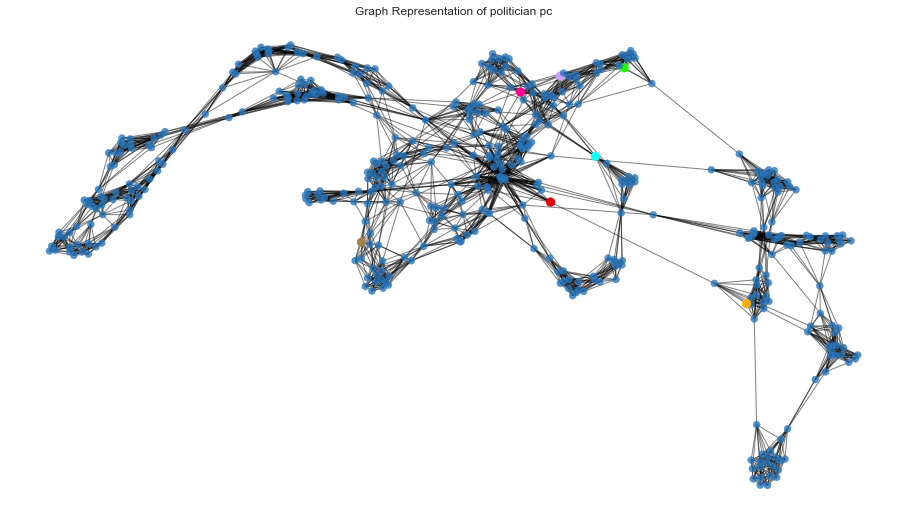

In [31]:
#Plotting the graph
def highlight_nodes_network(councelor_df,G,pos,clusters = pd.DataFrame()):
    plt.figure(figsize=(16,9))
    if (clusters.empty):
        ## assign a node attribute
        federal_counselor_dict = {x["idx"] : write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()}
        federal_counselor_dict[0] = "Some rando"
    else :
        tmp = {x["idx"] : write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()}
        federal_counselor_dict = {c["Nodes"] : i for i,c in clusters.iterrows()}
        federal_counselor_dict.update(tmp)

    for node in G.nodes():
        G.node[node]['federal_counselor'] = federal_counselor_dict.get(node, "Some rando")

     ## Create list of plotting attributes 
    labels = [write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()]
    idx = federal_counselor_votes["idx"].values
    
    if (clusters.empty):
        color_map = {name : color for name,color in zip(labels,colors)} 
        color_map["Some rando"] = "xkcd:bluish"
        alpha_map = {name : 1 for name in labels}
        alpha_map["Some rando"] = .8
        size_map = {name :80 for name in labels } 
        size_map["Some rando"] = 50
    else :
        tmpc= {name : color for name,color in zip(labels,colors)} 
        clusters_color = ["xkcd:aquamarine","xkcd:pale blue","xkcd:mint green","xkcd:baby blue","xkcd:robin's egg blue","xkcd:powder blue","xkcd:azure"]
        color_map = {i:c for i,c in zip(range(7),clusters_color)}
        color_map.update(tmpc)
        tmpa = {name : 1 for name in labels}
        alpha_map = {i:.8 for i in range(7)}
        alpha_map.update(tmpa)
        tmps = {name :80 for name in labels } 
        size_map =  {i:50 for i in range(7)}
        size_map.update(tmps)

    nodes_colors = [color_map[G.node[node]['federal_counselor']] for node in G]
    nodes_sizes = [size_map[G.node[node]['federal_counselor']] for node in G]
    nodes_alphas = [alpha_map[G.node[node]['federal_counselor']] for node in G]
    ## plotting the graph with given atttributes
    nx.draw_networkx_nodes(G,pos, node_color=nodes_colors,node_size=nodes_sizes,alpha=nodes_alphas)
    nx.draw_networkx_edges(G, pos, alpha=.5)
    plt.axis('off')

    plt.title("Graph Representation of politician pc")
    plt.show()
    
highlight_nodes_network(federal_counselor_votes,knn_graph,knn_graph_plot_pos)

Again all nodes seems to concentrate around the center. It also interesting to note that all points seems somehow well connected. It would seems like a good criteria for a exectutive represent to be a "hub" of the graph as it would mean they have a voting pattern similar to more people and therefore would be representative of more people. Let's take a closer look at the "hub" propriety of our three counselor.

### 3.2.3 Node Degree Distribution

Christoph Blocher (UDC) 11
Ueli Maurer (UDC) 12
Johann N. Schneider-Ammann (PRD) 12
Guy Parmelin (UDC) 11
Didier Burkhalter (PRD) 14
Viola Amherd (PDC) 10
Ignazio Cassis (PLR) 15


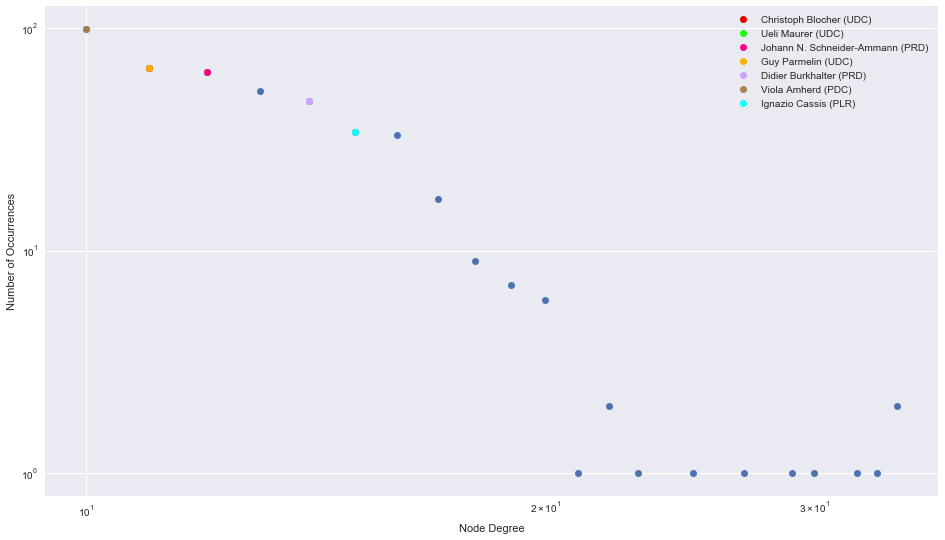

In [32]:
def plot_degree_distribution(graph,councelor_df):
    plt.figure(figsize=(16,9))
    deg = np.array(graph.degree())[:,1]
    val, count = np.unique(deg, return_counts=True)
    dict_hist = dict(zip(val, count))
    labels = [write_names(x["FirstName"],x['LastName'], x['PartyAbbreviation']) for i,x in councelor_df.iterrows()]
    plt.loglog(val, count, 'o')
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Occurrences")
    for c,(id,l) in zip(colors,zip(councelor_df["idx"],labels)) :
        val = graph.degree(id)
        print(l,val)
        plt.loglog(val,dict_hist[val], 'o',label = l,c=c)
    plt.legend()
plot_degree_distribution(knn_graph,federal_counselor_votes)    

Some of them are somewhat well connected, but most are not. Rationally it would seem that the more connected a point is, the more people are agreeing with it. We can make the hypothesis that a good executive power memeber is someone who agrees with the most members of the legislative power. This make sense if we want the law makers to be happy with the way the law is applied. Here the process of election is complicated and not based on any pre-defined criteria. The result seem to be individual not necessarly representative of a majority. It would be interesting to see how centered they are in their own party (TODO). 

NB: Some point are not visible because they overlap with others, this is why we also printed out the degrees.

## 3.3 Picking a "Better" Executive Power

### 3.3.1 Picking the Nodes from Spectral Clusters

Following the hypothesis that a well connected individual is a good fit for a federal counselors, we can try and derive the best fit from the data. We can make the additional hypothesis that the set of 7 counselors need to cover the full spectrum of political view in the national council. To do so we use the spectral clustering from part one to create 7 clusters and select the most connected node from each.

In [33]:
# Here we reuse the 7 clusters spectral clustering that we computed above
clusters = pd.DataFrame({"Nodes":knn_graph.nodes(),"Clusters":spec_cl_7,"Degree":[knn_graph.degree(n) for n in knn_graph.nodes()]})
clusters = clusters.set_index("Clusters")
# Here we pick for each degree the latest node which gives us the most recent concelor
max_per_clusters = clusters.groupby(["Clusters","Degree"]).last().groupby("Clusters").last()

Let's see who those councelors are:

In [34]:
councillorids = [ids_to_CouncillorId[x["Nodes"]] for i,x in max_per_clusters.iterrows() ]
better_counselor_df = full_votes.loc[full_votes["CouncillorId"].isin(councillorids)]
better_counselor_df = better_counselor_df[["FirstName","LastName","PartyAbbreviation","CouncillorId"]].drop_duplicates(["FirstName","LastName"])
better_counselor_df = better_counselor_df.set_index("CouncillorId")
better_counselor_df["idx"] = list(map(lambda x : CouncillorId_to_idx[x] ,better_counselor_df.index))

In [35]:
better_counselor_df

,FirstName,LastName,PartyAbbreviation,idx
CouncillorId,,,,
94,Christine,Goll,PSS,10
3901,Lukas,Reimann,UDC,248
352,Ulrich,Schlüer,UDC,55
1140,Laura,Sadis,PRD,171
4057,Cédric,Wermuth,PSS,292
4142,Beat,Walti,PLR,365
4167,Magdalena,Martullo-Blocher,UDC,385


> Several observation can already be made : 
- There is no overlapping with the actual list of federal concelor 
- The whole political spectrum is represented  
- The Extrems are overrepresented 

Those observations are based on this spectrum from "Le Temps". 

NB: the PDR can be assimilated to the PLR

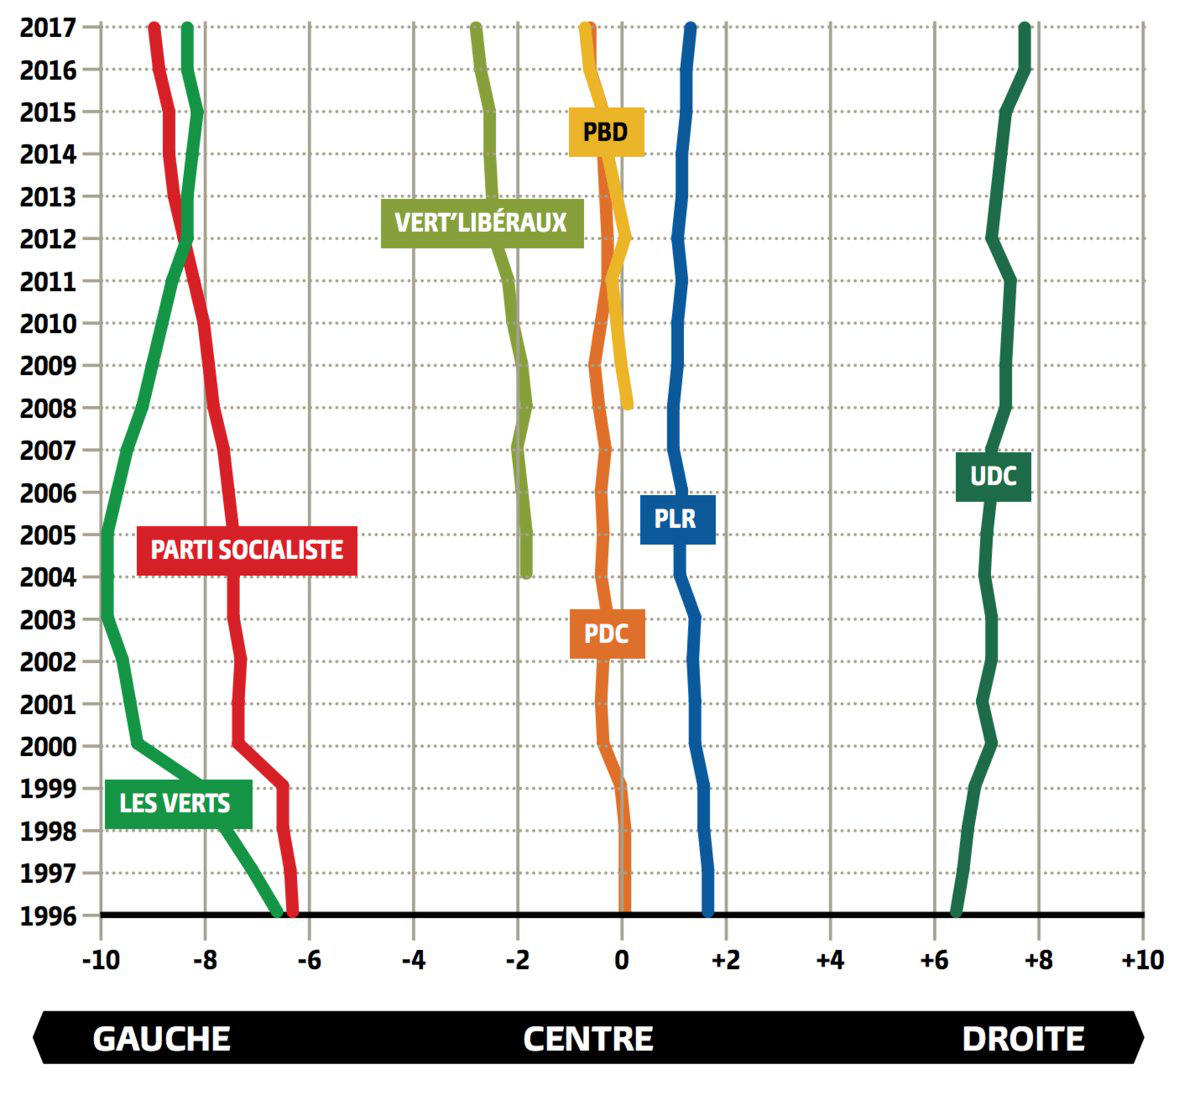

In [36]:
from PIL import Image
from io import BytesIO
import requests
url = "https://assets.letemps.ch/sites/default/files/styles/share/public/media/2017/12/07/file6xvmqbr36s4soxt5kjm.png.jpeg?itok=UHqSuRlU"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

### 3.3.2 Graph Representation
We can see where thoses points are on the graph, and visualize them in the context of the spectral clusters that we defined

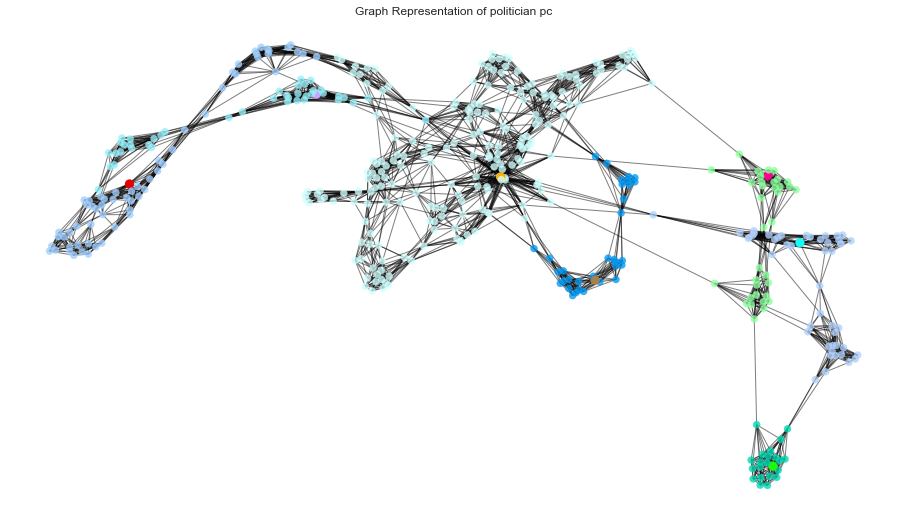

In [37]:
highlight_nodes_network(better_counselor_df,knn_graph,knn_graph_plot_pos,clusters)

We see that they are nicely at the centers of different "clusters" on the graph and span over all major centers.

### 2.3.3 TSNE Representation 

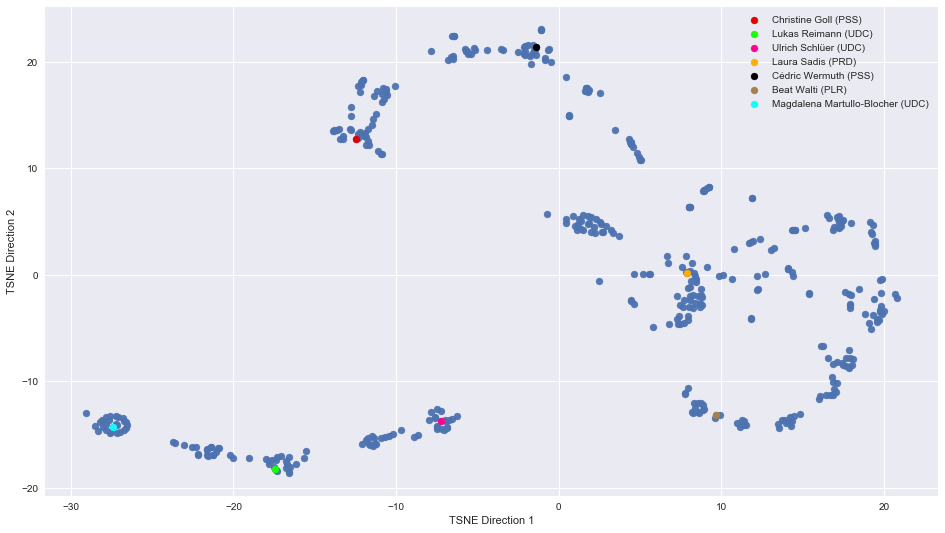

In [38]:
highlight_nodes_tsne(better_counselor_df,tsne)

We see that they are somehow "uniformly" spanning across the figures  and are always in the centers of what could be identified as clusters (TODO: show the party cluster on the map).

### 2.3.4 Identifing the Span of Agreement
At this point it would be interesting to visualize what part of the legislative counslor would be represented by each of out pick of federal counselor. This can be performed by doing one iteration of KMeans using the counselors as initalization points.  

/anaconda3/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


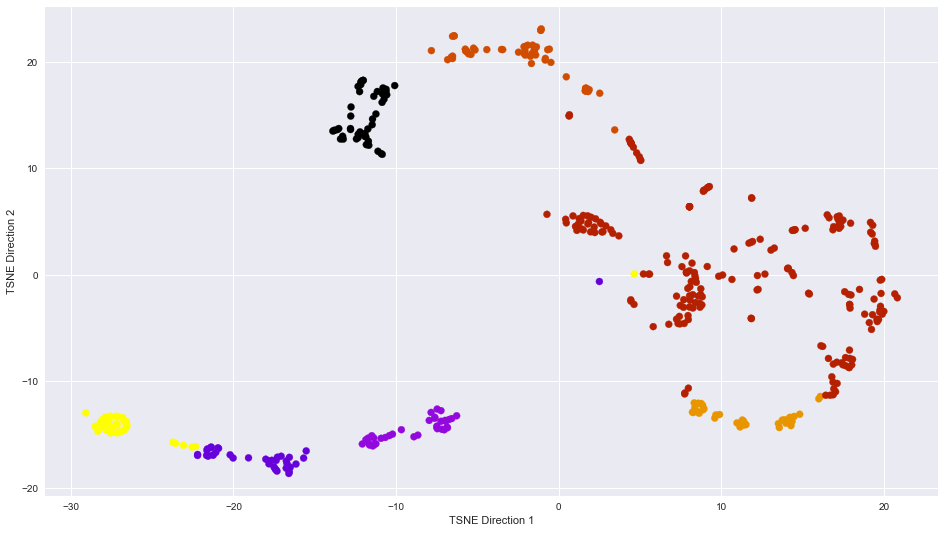

In [43]:
plt.figure(figsize=(16,9))
seeds = np.asarray([pc[x["idx"],:] for i,x in better_counselor_df.iterrows() ])
cl = KMeans(n_clusters=7,init=seeds,max_iter=1).fit(pc)
visualize_clusterings(tsne, cl.labels_)


It therefore seems that our pick of federal concelor is good under our two hypotesis. Except for some outliers, if we map the representation of our 7 counselor over the legislative power, it seems that everyone would be a could representent for a subgroup. Let's see if all members are representative of an equal numbers of people:

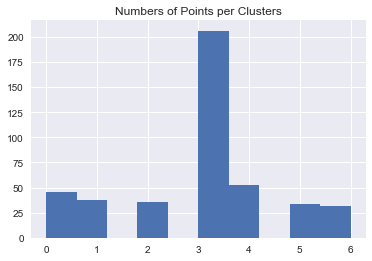

In [44]:
kmean_cluster = pd.DataFrame(cl.labels_)
kmean_cluster.hist()
plt.title("Numbers of Points per Clusters")
plt.show()

Here we can see that one of the counselor is representative or many more than the others. This could be a drawback of our method and we might want to mediate to this in futur analysis.  

### What we've learned 

The organic choice of federal counsilors might be problematic. Assuming that someone voting pattern is representative of his political orientation the counsilors are not representative of the orientation of large groups. This "isolatetness" could lead to unsatisfactory decision taking (TODO: is this the case?). 

A way of picking better executive power would be to pick hubs of 7 artifically created voting pattern clusters. In this way, the 7 federal counslors would be an optimal representation of the legislative power. 

# And Now What ?

Taking on Political parties:
- Compare the clustering obtained from the data to the actual political parties, in order to see how well they explain the data.

Deepening the critizim of federal councelors selection:
- Come up with validation technics
- Have a better balance in size of representation after 1 iteration KMeans clustering
- See the real federal councelor in the context of their political party

Taking into account time:
- So far we've only looked at all votes simultaneously. However, the composition of the parliament changes every 4 years, so it would make sense to look at the 3 legislatures present in our data separately. 
- Look at whether we can recover party split of SVP into SVP and BDP in November 2008. If we can recover it, this means that parties are well-represented in the voting data.
- Look whether the party isolation changes over time - do we see an increasing political divide? This would make parties more (or less) reasonable with time.

Assesing impact of party support:
- We wanted to see how important parties were to obtain support for political motions. For this we need to know for every motion who proposed it. This data we can for now only obtain with a web-crawl which is really slow due to the slow website. The API is only implemented in 2020, and accessing this data directly seems impossible. We therefore have to assess whether this part is feasible at all.